In [6]:
%pylab inline
import numpy as np
from tqdm import trange

Populating the interactive namespace from numpy and matplotlib


In [7]:
def fetch(url):
    import os, hashlib, requests, gzip
    fp = os.path.join("/home/klaas/Projects/Mnist", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.set_printoptions(sci_mode=False)

class BobNet(nn.Module):
    def __init__(self):
        super(BobNet, self).__init__()
        self.l1 = nn.Linear(784, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)
        self.sm = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = self.sm(x)
        return x

loss 0.12 accuracy 0.97: 100%|█████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 414.88it/s]


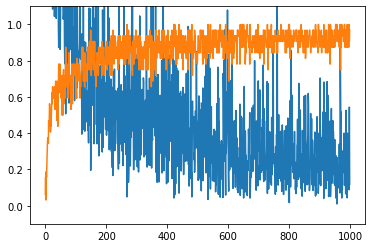

In [21]:
model = BobNet()
loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS = 32
losses, accuracies = [], []

for i in (t := trange (1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.Tensor(X_train[samp].reshape((-1, 28*28))).float()
    Y = torch.Tensor(Y_train[samp]).long()
    model.zero_grad()
    
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

In [23]:
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()


0.9113

In [40]:
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)
    return x

def numpy_eval():
    Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
    Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
    return (Y_test_preds == Y_test).mean()
numpy_eval()

0.9113

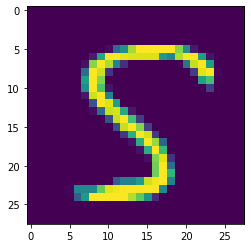

In [47]:
imshow(X_test[333])

In [48]:
torch.argmax(model(torch.Tensor(X_test[333].reshape((-1, 28*28)))))

tensor(5)

In [ ]:
def logsumexp(x):
    c = np.max(axis=1)
    return c + np.log(np.exp(x-c.reshape((-1, 1)))).sum(axis=1)

def forward_backward(x, y):
    out = np.zeroes((len(y), 10))